
 minimum disparity = -1.0

 maximun disparity = 15.0


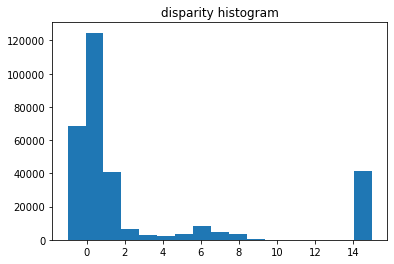

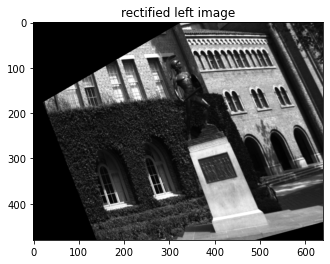

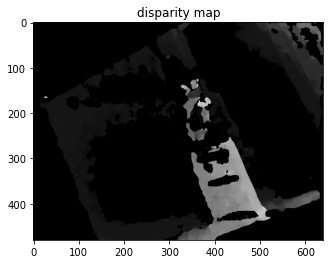

(-1, None)

In [1]:
# 예제 10.3-2 프로그램
##  ok

import cv2
import matplotlib.pyplot as plt
import numpy as np

dst1 = cv2.imread('../../data/TOMMY2_L.png', 0)
dst2 = cv2.imread('../../data/TOMMY2_R.png', 0)
dst1 = cv2.resize(dst1, dsize=(640,480), interpolation=cv2.INTER_AREA)
dst2 = cv2.resize(dst2, dsize=(640,480), interpolation=cv2.INTER_AREA)

img_size = dst1.shape[::-1] # img_size 높이와 폭 값 교환

### Obtain feature points with SIFT
sift = cv2.xfeatures2d.SIFT_create(contrastThreshold=0.09)
kp1, des1 = sift.detectAndCompute(dst1,None)
kp2, des2 = sift.detectAndCompute(dst2,None)

### FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []
### ratio test 
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)

# 거리값을 기준으로 정렬
sorted_good = sorted(good, key = lambda x : x.distance)        
for m in sorted_good :
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)
     
pts1 = np.array(pts1) # np 배열로 변환, float64 타입
pts2 = np.array(pts2)

# get fundamental matrix
F,mask= cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# 인-라이어만 선택, 타입 변환
pts1 = np.int32(pts1[mask.ravel()==1])
pts2 = np.int32(pts2[mask.ravel()==1])

# get homography from fundamental matrix
p1fNew = pts1.reshape((pts1.shape[0] * 2, 1))
p2fNew = pts2.reshape((pts2.shape[0] * 2, 1))
retB,rectM1,rectM2 = cv2.stereoRectifyUncalibrated(p1fNew,p2fNew,
                                                   F,img_size,3)
# transform with homography
dst11 = cv2.warpPerspective(dst1,rectM1,img_size)
dst22 = cv2.warpPerspective(dst2,rectM2,img_size)

#calculation of the disparity
paras = dict(minDisparity=0, preFilterCap=150, P1=100, P2=1000, 
             uniquenessRatio=5,speckleRange=3, speckleWindowSize=200, mode=1)
stereo = cv2.StereoSGBM_create(numDisparities=16, blockSize=15,**paras)
disp = stereo.compute(dst11, dst22).astype(np.float32)/16

print('\n minimum disparity =', np.min(disp))
print('\n maximun disparity =', np.max(disp))
#print(disp[50:51][0:40])

# disparity plot
dList = disp.flatten().tolist()
plt.hist(dList, bins=17), plt.title('disparity histogram'), plt.show()

disp = np.clip(disp, 0, np.max(disp))
disp = np.where(disp > 12, 0, disp)

# Normalize between 0 and 255 in 8 bit one-channel 
disp = cv2.normalize(src=disp, dst=None, alpha=0, beta=255, 
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

plt.imshow(dst11, 'gray'), plt.title('rectified left image'), plt.show()
plt.imshow(disp,'gray'), plt.title('disparity map'), plt.show()

cv2.waitKey(0), cv2.destroyAllWindows()
